In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import math
from scipy.integrate import odeint
import sympy as sp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import *
import os
import emcee
import matplotlib.pyplot as plt
import corner
import configparser

from scipy.optimize import minimize
from numba import jit

from IPython.display import display, Math

In [2]:
current_directory = os.getcwd()


config = configparser.ConfigParser()
config.read('setting.ini')
Modelname = config.get('Settings', 'Modelname')
Mode = config.get('Settings', 'Mode')
UseCovMatrix = config.getboolean('Settings', 'UseCovMatrix')

if Modelname == "proptoscale":
    fsigma_directory = os.path.join(current_directory, "data/proptoscale")
    output_directory = os.path.join(current_directory, "emcee_result/proptoscale")
    Numbin = 3
elif Modelname == "proptoOmega":
    fsigma_directory = os.path.join(current_directory, "data/proptoOmega")
    output_directory = os.path.join(current_directory, "emcee_result/proptoOmega")
    Numbin = 2
elif Modelname == "proptoHubble":
    fsigma_directory = os.path.join(current_directory, "data/proptoHubble")
    output_directory = os.path.join(current_directory, "emcee_result/proptoHubble")    
    Numbin = 2


cov_file_path =  os.path.join(current_directory, "data/covs.ini")
mean_file_path =  os.path.join(current_directory, "data/means.ini")    

In [3]:
Omegam0_fix=0.3069 # matter
aeq=1/3300  #matter-radiation equality
initial_eta=-5  #initial_eta
sigma8_0=0.811207  #sigma8_0 in LCDM case (at Omegam0=0.27)
num = 10000
m_exp=2.0
Ommean = 0.3069        #cf. arXiv2404.03002
Omsigma = 0.0050 



background = "LCDM"     #LCDM or w0wa_DESI cf.eq.(5.6) in arXiv:2404.03002
w0_DESI = -0.827
wa_DESI = -0.75



#Mu and Omegam parameter range
mu1_lower = 0.5
mu1_upper = 2.0
mu2_lower = 0.5
mu2_upper = 2.0
mu3_lower = 0.5
mu3_upper = 2.0
Omegam0_lower = 0.1
Omegam0_upper = 0.5

mu1_ini = 1.01
mu2_ini = 1.01
mu3_ini = 1.01
if Numbin == 2:
    initial = np.array([mu1_ini, mu2_ini])
else:
    initial = np.array([mu1_ini, mu2_ini,mu3_ini])

cB_pm = "plus"  # "plus":positive definite or "minus":negative definite


if Mode == "cB=-cM":
    cB_pm = "minus"

In [4]:
### The definition of functions
if background == "LCDM":
    @jit
    def hubble_function(eta,Omegam0):
        return (Omegam0*(math.exp(eta))**(-3)+(1-Omegam0))**0.5
    @jit
    def hubble2(eta,Omegam0):
    ###Hubble squared
        return Omegam0*(math.exp(eta))**(-3)+(1-Omegam0)
    @jit
    def Omega_lambda(eta,Omegam0):
        return (1-Omegam0)/hubble_function(eta,Omegam0)**2
    @jit
    def Omega_matter(eta,Omegam0):
        return 1-(1-Omegam0)/hubble_function(eta,Omegam0)**2

    @jit
    def hubble_dot(eta,Omegam0):
    ###    time derivative of the Hubble function
        return (-3/2)*hubble_function(eta,Omegam0)**2*(1-Omega_lambda(eta,Omegam0))    

elif background == "w0wa_DESI":
    @jit    
    def hubble_function(eta,Omegam0):
        return (Omegam0*(math.exp(eta))**(-3)+(1-Omegam0)*  math.exp(eta)**(-3-3*w0_DESI-3*wa_DESI)*math.exp(-3*wa_DESI*(1-math.exp(eta)))  )**0.5
    @jit
    def hubble2(eta,Omegam0):
        return Omegam0*(math.exp(eta))**(-3)+(1-Omegam0)*   math.exp(eta)**(-3-3*w0_DESI-3*wa_DESI)*math.exp(-3*wa_DESI*(1-math.exp(eta))) 
    @jit
    def Omega_lambda(eta,Omegam0):
        return (1-Omegam0)*(    math.exp(eta)**(-3-3*w0_DESI-3*wa_DESI)*math.exp(-3*wa_DESI*(1-math.exp(eta)))   )/hubble_function(eta,Omegam0)**2
    @jit
    def Omega_matter(eta,Omegam0):
        return 1-Omega_lambda(eta,Omegam0)
    @jit
    def hubble_dot(eta,Omegam0):
        return (-3/2)*hubble_function(eta,Omegam0)**2*(1-Omega_lambda(eta,Omegam0))    

@jit
def mu(mu1, mu2, mu3, eta):
        if eta >= math.log(0.5):
            return mu1
        elif eta >= math.log(0.25):
            return mu2
        elif eta >= math.log(0.1):
            return mu3
        else:
            return 1
        
def find_nearest_index(array, i):
    absolute_differences = np.abs(array - i)  # Calculate the absolute value of the difference between each element and i
    nearest_index = np.argmin(absolute_differences)  # Get the index of the minimum value
    return nearest_index

In [5]:
    # Set time range
    eta_domain = np.linspace(initial_eta, 0, num)  # Divide initial_eta to 0 by num=10000
    
# Create an empty array to store the results
    z_result_array = np.empty_like(eta_domain)


# Use a loop to apply a function to each element of an array
    for i, value in enumerate(eta_domain):
        z_result_array[i] = 1/math.exp(value)-1
    
    #Initial condtion
    #We assume  delta=deltam_0*(1+1.5*(a/aeq)) at initial value and deltam_0=1
    initial_delta=1+1.5*(math.exp(initial_eta)/aeq)
    initial_delta_prime=1.5*(math.exp(initial_eta)/aeq)
    initial_value=np.array([initial_delta,initial_delta_prime])

In [6]:
if Numbin == 2:
    def log_likelihood(theta, x, y, yerr):
        mu1, mu2 = theta
        mu3 = 1.0
        sigma2 = yerr**2
    
    ################
        def delta_derivatives(delta, eta):
            return [delta[1], -(1+3*Omega_lambda(eta,Omegam0_fix))*delta[1]/2+mu(mu1, mu2, mu3, eta)*(3/2)*Omega_matter(eta,Omegam0_fix)*delta[0]]
    
        delta, delta_prime = odeint(delta_derivatives, initial_value, eta_domain).T 
        delta_0_LCDM=3829.726782313616
        late_delta = delta[-2500:]*sigma8_0/delta_0_LCDM
        late_delta_prime = delta_prime[-2500:]*sigma8_0/delta_0_LCDM
        late_eta_domain = eta_domain[-2500:]
        late_z_array = z_result_array[-2500:]
    
        fsigma = np.empty_like(x)
        j = 0
        for z_obs in x:
            zobs_index = find_nearest_index(late_z_array, z_obs)
            fsigma[j]=late_delta_prime[zobs_index]
            j=j+1
    ################
    
        return -0.5 * np.sum((y - fsigma) ** 2 / sigma2 + np.log(sigma2))



else:
    def log_likelihood(theta, x, y, yerr):
        mu1, mu2, mu3, = theta
        sigma2 = yerr**2
    
    ################
        def delta_derivatives(delta, eta):
            return [delta[1], -(1+3*Omega_lambda(eta,Omegam0_fix))*delta[1]/2+mu(mu1, mu2, mu3, eta)*(3/2)*Omega_matter(eta,Omegam0_fix)*delta[0]]
    
        delta, delta_prime = odeint(delta_derivatives, initial_value, eta_domain).T 
    
        delta_0_LCDM=3829.726782313616
        late_delta = delta[-2500:]*sigma8_0/delta_0_LCDM
        late_delta_prime = delta_prime[-2500:]*sigma8_0/delta_0_LCDM
        late_eta_domain = eta_domain[-2500:]
        late_z_array = z_result_array[-2500:]
    
        fsigma = np.empty_like(x)
        j = 0
        for z_obs in x:
            zobs_index = find_nearest_index(late_z_array, z_obs)
            fsigma[j]=late_delta_prime[zobs_index]
            j=j+1
    ################
    
        return -0.5 * np.sum((y - fsigma) ** 2 / sigma2 + np.log(sigma2))

In [7]:
if Numbin == 2:
    def log_prior(theta):
        mu1, mu2 = theta
        if mu1_lower < mu1 < mu1_upper and mu2_lower < mu2 < mu2_upper:     #set parameter domain
            return 0.0
        return -np.inf
else:
    def log_prior(theta):
        mu1, mu2, mu3 = theta
        if mu1_lower < mu1 < mu1_upper and mu2_lower < mu2 < mu2_upper and mu3_lower < mu3 < mu3_upper:     #set parameter domain
            return 0.0
        return -np.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)           #zero (theta in the parameter domain) or -Infty (otherwise)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

cB_hiclass=0.0, c_M=0.0


100%|█████████████████████████████████████| 10000/10000 [04:02<00:00, 41.23it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

cov=[[ 0.00594476 -0.00063824]
 [-0.00063824  0.00034332]]
mean=[1.00018871 0.99955791]
Mode : cB=0


<IPython.core.display.Math object>

95% lower 0.02126328614893863    95% upper 0.6854449097688247
cB_hiclass=0.0, c_M=0.2


100%|█████████████████████████████████████| 10000/10000 [04:03<00:00, 41.04it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

cov=[[ 0.00611128 -0.00065173]
 [-0.00065173  0.00034241]]
mean=[1.02131152 1.0069502 ]
Mode : cB=0


<IPython.core.display.Math object>

95% lower 0.037201640231959564    95% upper 0.8679197255561822
cB_hiclass=0.0, c_M=0.4


100%|█████████████████████████████████████| 10000/10000 [04:04<00:00, 40.91it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

cov=[[ 0.00612952 -0.00065377]
 [-0.00065377  0.00034631]]
mean=[1.04129983 1.01323297]
Mode : cB=0


<IPython.core.display.Math object>

95% lower 0.07102039850201805    95% upper 1.0654053024031547


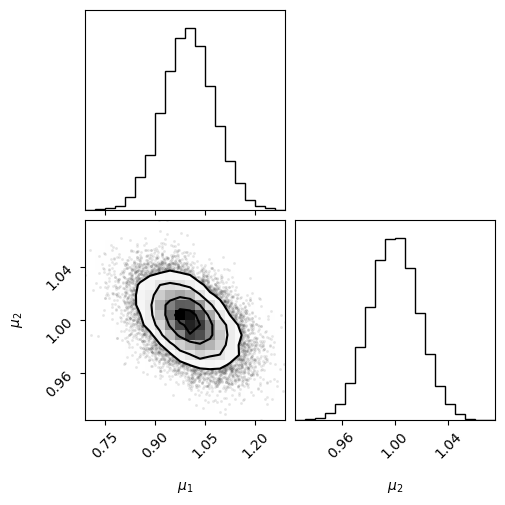

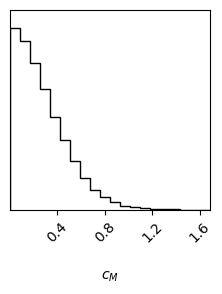

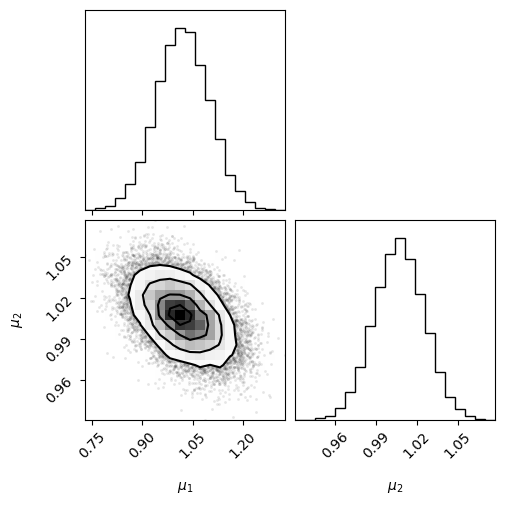

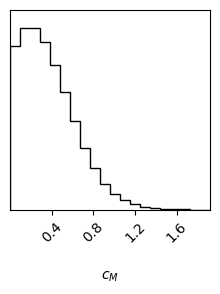

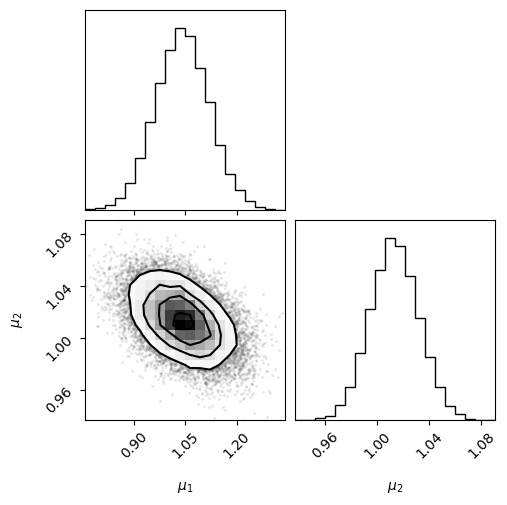

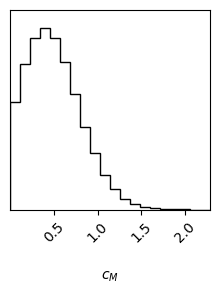

In [8]:
if Modelname == "proptoscale":
    if Mode == "cB=-cM":
        coordinates = [(0.0, 0.0),(-0.2, 0.2), (-0.4, 0.4)]
        def Mapping_array(x):
            return np.array([0.07393655190888457*x**2 + (0.49481915302419477-0.09213*(Omegam0_fix-0.3))*x + 1.0, 0.06405374352808658*x**2 + (0.382119332232108-0.033641*(Omegam0_fix-0.3))*x + 1.0, 0.003601722684269804*x**2 + (0.15243916153799664+0.20739*(Omegam0_fix-0.3))*x + 1.0])
    elif Mode == "cM=0":    
        coordinates = [(0.0, 0.0), (0.2, 0.0), (0.4, 0.0)]
        def Mapping_array(x):    
            return np.array([0.15952080716247255*x**2 + (0.29182345518220926+0.0795*(Omegam0_fix-0.3))*x + 1.0, 0.15204983018999055*x**2 + (0.28914741490616575+0.0741*(Omegam0_fix-0.3))*x + 1.0, 0.01280740209022846*x**2 + (0.2166314455908258+0.0231*(Omegam0_fix-0.3))*x + 1.0])
elif Modelname == "proptoOmega":
    if Mode == "cB=0":
        coordinates = [(0.0, 0.0),(0.0, 0.2), (0.0, 0.4)]
        def Mapping_array(x):
            return np.array([-0.02125338487219025*x**2 + (0.1126511514410319-0.189*(Omegam0_fix-0.3))*x + 1.0, -0.001050931970968277*x**2 + (0.03464096507264981-0.140*(Omegam0_fix-0.3))*x + 1.0])
    elif Mode == "cM=0":    
        coordinates = [(0.0, 0.0), (0.2, 0.0), (0.4, 0.0)]
        def Mapping_array(x): 
            return np.array([0.010614523026573215*x**2 + (0.09520654121061413-0.419*(Omegam0_fix-0.3))*x + 1.0, 0.000273325837216311*x**2 + (0.022146642229374562-0.105*(Omegam0_fix-0.3))*x + 1.0])
elif Modelname == "proptoHubble":
    coordinates = [(0.0, 0.0),(0.2, 0.0), (0.4, 0.0)]
    if m_exp==1.0:
        def Mapping_array(x):
            return np.array([0.002991649314364483*x**2 + (0.03583196348946879-0.187899*(Omegam0_fix-0.3))*x + 1.0, -6.5111925939965016e-05*x**2 + (0.0017303633569644223-0.010593*(Omegam0_fix-0.3))*x + 1.0])
    elif m_exp==2.0:
        if background == "LCDM":
            def Mapping_array(x):
                return np.array([0.02182399102281732*x**2 + (0.13627034170539223-0.39615*(Omegam0_fix-0.3))*x + 1.0, 0.0008498740331631138*x**2 + (0.031400775061394846-0.104796*(Omegam0_fix-0.3))*x + 1.0])        
        elif background == "w0wa_DESI":
            def Mapping_array(x):
                return np.array([0.0222*x**2 + (0.135-0.390*(Omegam0_fix-0.3))*x + 1.0, 0.000733*x**2 + (0.0319-0.108*(Omegam0_fix-0.3))*x + 1.0])        

        
        
if not (UseCovMatrix):
    for cB_hiclass, c_M in coordinates:
        print("cB_hiclass={}, c_M={}".format(cB_hiclass, c_M))

        # Reading data
        # Path of data file and output Fig
        if Modelname == "proptoHubble":
            data_path = fsigma_directory +f"/Mockdata_fsigma8_cb={cB_hiclass}_mexp={m_exp}_Om={Omegam0_fix}_{background}.dat"  # ファイルのパスは適切に変更してください
            fig_directory = os.path.join(output_directory, f"mucontour_cb={cB_hiclass}_mexp={m_exp}_{background}.pdf")
            fig2_directory = os.path.join(output_directory, f"Contour_Bin_cb={cB_hiclass}_mexp={m_exp}_{background}.pdf")
        else:
            data_path = fsigma_directory +f"/Mockdata_fsigma8_cb={cB_hiclass}_cm={c_M}_Om={Omegam0_fix}_{background}.dat"  # ファイルのパスは適切に変更してください
            fig_directory = os.path.join(output_directory, f"mucontour_cb={cB_hiclass}_cm={c_M}_{background}.pdf")
            fig2_directory = os.path.join(output_directory, f"Contour_Bin_cb={cB_hiclass}_cm={c_M}_{background}.pdf")
        

        #### Reading data
        data = np.loadtxt(data_path)
        # Get the x, y, and yerror columns
        x = data[:, 0]
        y = data[:, 1]
        yerr = data[:, 2]
        # Get the number of data
        N = len(x)
        #### Reading data end

    

        if Numbin == 2:
            pos_ini = array([mu1_ini, mu2_ini])
            pos = pos_ini + 1e-4 * np.random.randn(32, 2)
            labels = ["$\mu_1$", "$\mu_2$"]
        else:
            pos_ini = array([mu1_ini, mu2_ini, mu3_ini])
            pos = pos_ini + 1e-4 * np.random.randn(32, 3)
            labels = ["$\mu_1$", "$\mu_2$", "$\mu_3$"]
         #Here we generate the initial positions by adding a small random noise around pos_ini.


        nwalkers, ndim = pos.shape

        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, args=(x, y, yerr))

        sampler.run_mcmc(pos, 10000, progress=True);
    #running MCMC
#This method takes the initial position pos, the number of samples (10000 in this case), and progress=True to display a progress bar.
#Once MCMC sampling is complete, we have the samples that the walker walked through in the posterior distribution.

        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
#Use the sampler.get_chain() method to get the chain from the MCMC sample.
#Use the argument discard=100 to discard the first 100 steps.
#Use the argument thin=15 to thin out the samples every step of about half the autocorrelation time.
#(This reduces correlation and increases independence between samples.)
#Finally, use flat=True to get a flat list.


        fig = corner.corner(flat_samples, labels=labels, plot_contours=True, contourf_kwargs={"cmap": "viridis"} );
        fig.savefig(fig_directory)

        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))

        ndim = 1
    
        if cB_pm == "plus":
            nwalkers = 32
            p0 = np.random.rand(nwalkers, ndim)
            def log_prob(x, mean, cov):
                x_scal = x[0]
                if x_scal >= 0:
                    B=Mapping_array(x_scal)
                    diff = B - mean
                    return -0.5 * np.dot(diff, np.linalg.solve(covs, diff))
                else:
                    return -np.inf
            
        elif cB_pm == "minus":
            nwalkers = 32
            p0 = -np.random.rand(nwalkers, ndim)
            def log_prob(x, mean, cov):
                x_scal = x[0]
                if x_scal <= 0:
                    B=Mapping_array(x_scal)
                    diff = B - mean
                    return -0.5 * np.dot(diff, np.linalg.solve(covs, diff))
                else:
                    return -np.inf        
        

        means = mean(sampler.flatchain, axis=0)
        covs = cov(sampler.flatchain.T) 

        print(f"cov={covs}")
        print(f"mean={means}")


        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, covs])
        state = sampler.run_mcmc(p0, 100)
        sampler.reset()
        sampler.run_mcmc(state, 10000);
        samples = sampler.get_chain(flat=True)


        print(f"Mode : {Mode}")
        for k in range(ndim):
       #Use np.percentile to calculate the 16, 50, and 84 percentiles (i.e. 68% confidence intervals) from a flat sample.
            mcmc = np.percentile(samples[:, k], [16, 50, 84])
            mcmc2 = np.percentile(samples[:, k], [5, 95])   
       #Calculate the width of the confidence interval.
            q = np.diff(mcmc)
            if Mode == "cB=0":
                txt = "c_M = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
                clabels=["$c_M$"]
                fig2 = corner.corner(samples, labels=clabels, plot_contours=True, contourf_kwargs={"cmap": "viridis"} );
                fig2.savefig(fig2_directory)
            else:
                txt = "c_B = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"      
                clabels=["$c_B$"]
                fig2 = corner.corner(samples, labels=clabels, plot_contours=True, contourf_kwargs={"cmap": "viridis"} );
                fig2.savefig(fig2_directory)
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))             
            print(f"95% lower {mcmc2[0]}    95% upper {mcmc2[1]}")       

In [9]:
#Omegam0_ini = 0.3
#initial = np.array([mu1_ini, mu2_ini, Omegam0_ini])

if Numbin == 2:
    def log_likelihood(theta, x, y, yerr):
        mu1, mu2, Omegam0 = theta
        mu3 = 1.0
        sigma2 = yerr**2
    
    ################
        def delta_derivatives(delta, eta):
            return [delta[1], -(1+3*Omega_lambda(eta,Omegam0))*delta[1]/2+mu(mu1, mu2, mu3, eta)*(3/2)*Omega_matter(eta,Omegam0)*delta[0]]
    
        delta, delta_prime = odeint(delta_derivatives, initial_value, eta_domain).T 
    
        delta_0_LCDM=3829.726782313616
        late_delta = delta[-2500:]*sigma8_0/delta_0_LCDM
        late_delta_prime = delta_prime[-2500:]*sigma8_0/delta_0_LCDM
        late_eta_domain = eta_domain[-2500:]
        late_z_array = z_result_array[-2500:]
    
        fsigma = np.empty_like(x)
        j = 0
        for z_obs in x:
            zobs_index = find_nearest_index(late_z_array, z_obs)
            fsigma[j]=late_delta_prime[zobs_index]
            j=j+1
    ################
    
        return -0.5 * np.sum((y - fsigma) ** 2 / sigma2 + np.log(sigma2))



else:
    def log_likelihood(theta, x, y, yerr):
        mu1, mu2, mu3, Omegam0 = theta
        sigma2 = yerr**2
    
    ################
        def delta_derivatives(delta, eta):
            return [delta[1], -(1+3*Omega_lambda(eta,Omegam0))*delta[1]/2+mu(mu1, mu2, mu3, eta)*(3/2)*Omega_matter(eta,Omegam0)*delta[0]]
    
        delta, delta_prime = odeint(delta_derivatives, initial_value, eta_domain).T 
    
        delta_0_LCDM=3829.726782313616
        late_delta = delta[-2500:]*sigma8_0/delta_0_LCDM
        late_delta_prime = delta_prime[-2500:]*sigma8_0/delta_0_LCDM
        late_eta_domain = eta_domain[-2500:]
        late_z_array = z_result_array[-2500:]
    
        fsigma = np.empty_like(x)
        j = 0
        for z_obs in x:
            zobs_index = find_nearest_index(late_z_array, z_obs)
            fsigma[j]=late_delta_prime[zobs_index]
            j=j+1
    ################
    
        return -0.5 * np.sum((y - fsigma) ** 2 / sigma2 + np.log(sigma2))

In [10]:
if Numbin == 2:
    def log_prior(theta):
        mu1, mu2, Omegam0 = theta
        if mu1_lower < mu1 < mu1_upper and mu2_lower < mu2 < mu2_upper and Omegam0_lower < Omegam0 < Omegam0_upper:     #set parameter domain
            return - 0.5 * (Ommean - Omegam0)**2 /Omsigma **2 
        return -np.inf
else:
    def log_prior(theta):
        mu1, mu2, mu3, Omegam0 = theta
        if mu1_lower < mu1 < mu1_upper and mu2_lower < mu2 < mu2_upper and mu3_lower < mu3 < mu3_upper and Omegam0_lower < Omegam0 < Omegam0_upper:     #set parameter domain
            return - 0.5 * (Ommean - Omegam0)**2 /Omsigma **2 
        return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)           #zero (theta in the parameter domain) or -Infty (otherwise)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

cB_hiclass=0.0, c_M=0.0


100%|█████████████████████████████████████| 10000/10000 [04:08<00:00, 40.22it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cov=[[ 6.21830265e-03 -5.66723776e-04 -7.70440071e-05]
 [-5.66723776e-04  3.61031022e-04 -2.35669407e-05]
 [-7.70440071e-05 -2.35669407e-05  2.49044344e-05]]
mean=[1.00080705 1.00001202 0.30683619]
Mode : cB=0


<IPython.core.display.Math object>

95% lower 0.02271381040813137    95% upper 0.7494849267094736


<IPython.core.display.Math object>

95% lower 0.2974414972224338    95% upper 0.3130387425041123
cB_hiclass=0.0, c_M=0.2


100%|█████████████████████████████████████| 10000/10000 [04:07<00:00, 40.35it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cov=[[ 6.29976396e-03 -5.93087741e-04 -7.56627798e-05]
 [-5.93087741e-04  3.64728300e-04 -2.26989987e-05]
 [-7.56627798e-05 -2.26989987e-05  2.48623943e-05]]
mean=[1.0214806  1.00664577 0.30682812]
Mode : cB=0


<IPython.core.display.Math object>

95% lower 0.037986268954072804    95% upper 0.9164486352611171


<IPython.core.display.Math object>

95% lower 0.29797037038265545    95% upper 0.31384538906257775
cB_hiclass=0.0, c_M=0.4


100%|█████████████████████████████████████| 10000/10000 [04:08<00:00, 40.24it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

cov=[[ 6.41375200e-03 -5.69087604e-04 -7.81414420e-05]
 [-5.69087604e-04  3.66708154e-04 -2.41569358e-05]
 [-7.81414420e-05 -2.41569358e-05  2.48404028e-05]]
mean=[1.04075342 1.01324016 0.30678317]
Mode : cB=0


<IPython.core.display.Math object>

95% lower 0.0648395933913708    95% upper 1.1240048088391665


<IPython.core.display.Math object>

95% lower 0.2984533770833665    95% upper 0.314290592099515


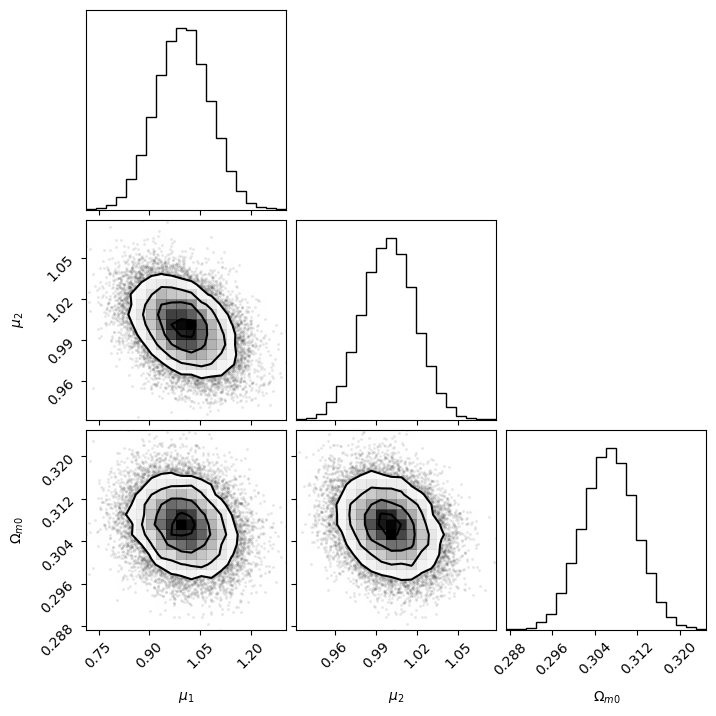

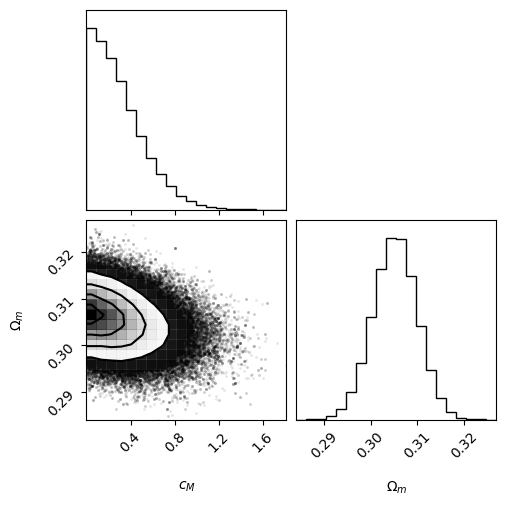

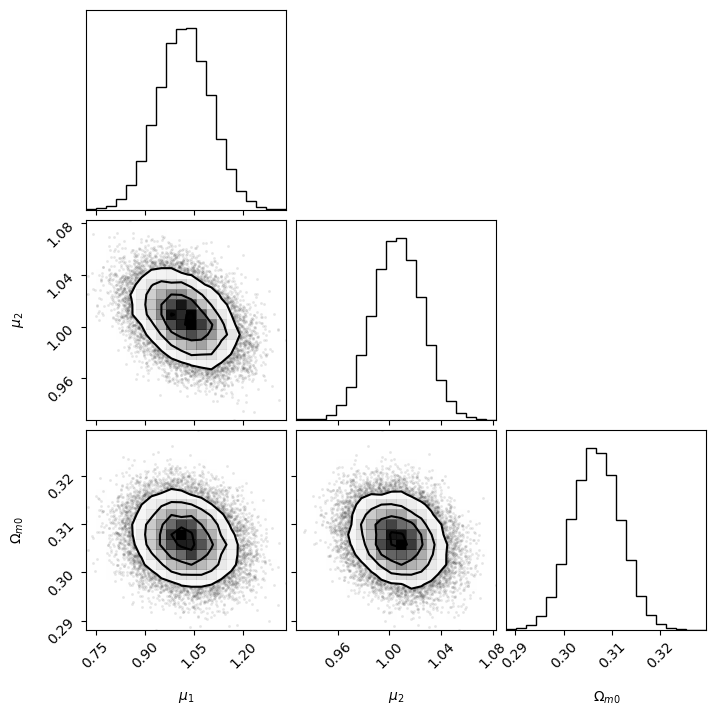

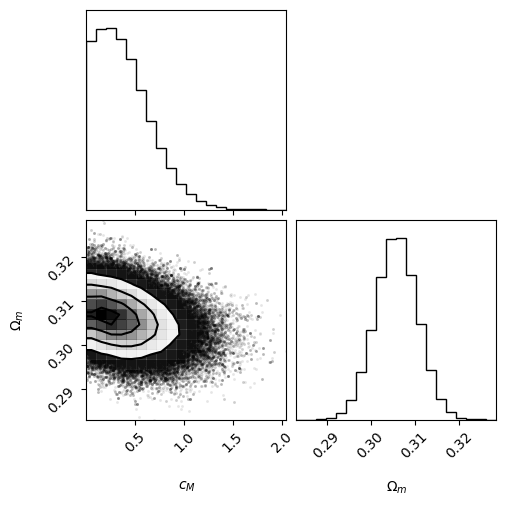

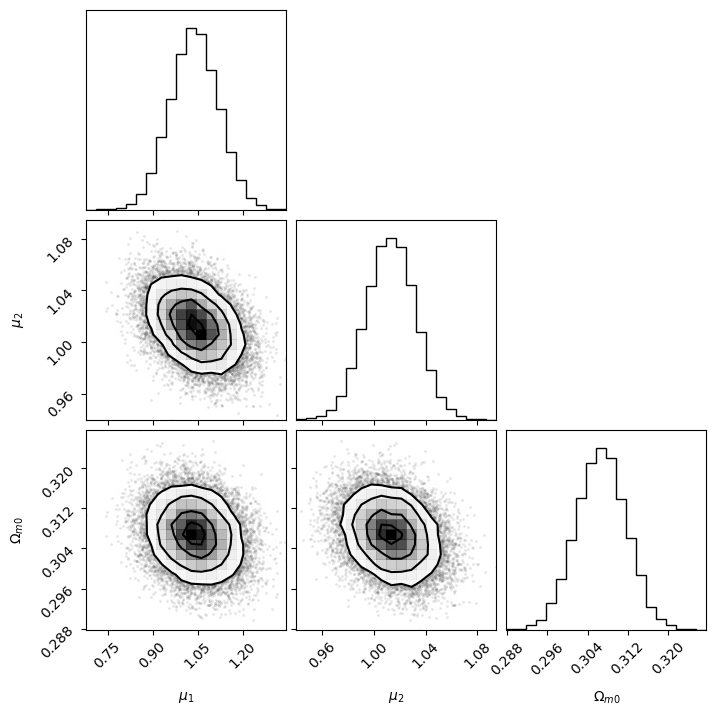

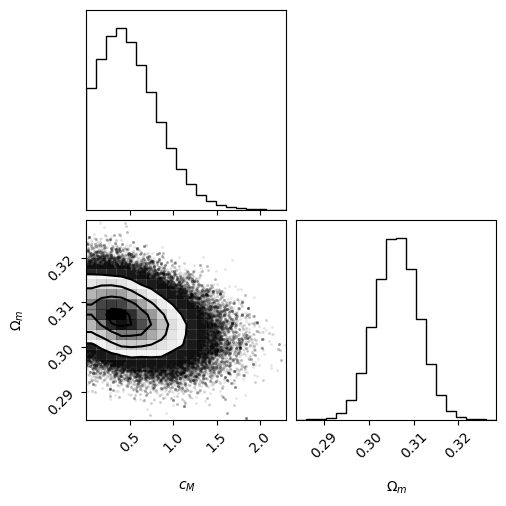

In [11]:
if Modelname == "proptoscale":
    if Mode == "cB=-cM":
        coordinates = [(0.0, 0.0),(-0.2, 0.2), (-0.4, 0.4)]
        def Mapping_array(x,Om):
            return np.array([0.07393655190888457*x**2 + (0.49481915302419477-0.09213*(Om-0.3))*x + 1.0, 0.06405374352808658*x**2 + (0.382119332232108-0.033641*(Om-0.3))*x + 1.0, 0.003601722684269804*x**2 + (0.15243916153799664+0.20739*(Om-0.3))*x + 1.0, Om])
    elif Mode == "cM=0":    
        coordinates = [(0.0, 0.0), (0.2, 0.0), (0.4, 0.0)]
        def Mapping_array(x,Om):    
            return np.array([0.15952080716247255*x**2 + (0.29182345518220926+0.0795*(Om-0.3))*x + 1.0, 0.15204983018999055*x**2 + (0.28914741490616575+0.0741*(Om-0.3))*x + 1.0, 0.01280740209022846*x**2 + (0.2166314455908258+0.0231*(Om-0.3))*x + 1.0, Om])
elif Modelname == "proptoOmega":
    if Mode == "cB=0":
        coordinates = [(0.0, 0.0),(0.0, 0.2), (0.0, 0.4)]
        def Mapping_array(x,Om):
            return np.array([-0.02125338487219025*x**2 + (0.1126511514410319-0.189*(Om-0.3))*x + 1.0, -0.001050931970968277*x**2 + (0.03464096507264981-0.140*(Om-0.3))*x + 1.0, Om])
    elif Mode == "cM=0":    
        coordinates = [(0.0, 0.0), (0.2, 0.0), (0.4, 0.0)]
        def Mapping_array(x,Om):    
            return np.array([0.010614523026573215*x**2 + (0.09520654121061413-0.419*(Om-0.3))*x + 1.0, 0.000273325837216311*x**2 + (0.022146642229374562-0.105*(Om-0.3))*x + 1.0,Om])
elif Modelname == "proptoHubble":
    coordinates = [(0.0, 0.0),(0.2, 0.0), (0.4, 0.0)]
    if m_exp==1.0:
        def Mapping_array(x,Om):
            return np.array([0.002991649314364483*x**2 + (0.03583196348946879-0.187899*(Omegam0_fix-0.3))*x + 1.0, -6.5111925939965016e-05*x**2 + (0.0017303633569644223-0.010593*(Omegam0_fix-0.3))*x + 1.0, Om])
    elif m_exp==2.0:
        if background == "LCDM":
            def Mapping_array(x,Om):
                return np.array([0.02182399102281732*x**2 + (0.13627034170539223-0.39615*(Omegam0_fix-0.3))*x + 1.0, 0.0008498740331631138*x**2 + (0.031400775061394846-0.104796*(Omegam0_fix-0.3))*x + 1.0, Om])        
        elif background == "w0wa_DESI":
            def Mapping_array(x,Om):    
                return np.array([0.0222*x**2 + (0.135-0.390*(Omegam0_fix-0.3))*x + 1.0, 0.000733*x**2 + (0.0319-0.108*(Omegam0_fix-0.3))*x + 1.0, Om])        



if (UseCovMatrix):
    # Fig path
    fig2_directory = os.path.join(output_directory, f"Contour_Cov_Bin_Modelname={Modelname}.pdf")
    
    ndim = 2    
    if Numbin == 2:
        labels = ["$\mu_1$", "$\mu_2$", "$\Omega_{m0}$"]
    else:    
        labels = ["$\mu_1$", "$\mu_2$", "$\mu_3$", "$\Omega_{m0}$"]    

    if cB_pm == "plus":
        nwalkers = 32
        p0 = np.random.rand(nwalkers, ndim)
        def log_prob(x, mean, cov):
            x_scal = x[0]
            Om_scal = x[1]
            if x_scal >= 0:
                B=Mapping_array(x_scal,Om_scal)
                diff = B - mean
                return -0.5 * np.dot(diff, np.linalg.solve(covs, diff))
            else:
                return -np.inf
    elif cB_pm == "minus":
        nwalkers = 32
        p0 = -np.random.rand(nwalkers, ndim)
        def log_prob(x, mean, cov):
            x_scal = x[0]
            Om_scal = x[1]
            if x_scal <= 0:
                B=Mapping_array(x_scal,Om_scal)
                diff = B - mean
                return -0.5 * np.dot(diff, np.linalg.solve(covs, diff))
            else:
                    return -np.inf

    
    file_path = 'matrix.txt'  
    covs = np.loadtxt(cov_file_path)
    means = np.loadtxt(mean_file_path)
    print(f"cov={covs}")
    print(f"mean={means}")


    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, covs])
    state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    sampler.run_mcmc(state, 10000);


    samples = sampler.get_chain(flat=True)
    print(f"Mode : {Mode}")
   
    for k in range(ndim):
        #Use np.percentile to calculate the 16th, 50th, and 84th percentiles (i.e. 68% confidence intervals) from a flat sample.        
        mcmc = np.percentile(samples[:, k], [16, 50, 84])
        mcmc2 = np.percentile(samples[:, k], [5, 95])   
        #Calculate the width of the confidence interval.        q = np.diff(mcmc)
        if (k==0):
            if Mode == "cB=0":
                txt = "c_M = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
                clabels=["$c_M$", "$\Omega_m$"]
                fig2 = corner.corner(samples, labels=clabels);
                fig2.savefig(fig2_directory)
            else:
                txt = "c_B = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"      
                clabels=["$c_B$", "$\Omega_m$"]
                fig2 = corner.corner(samples, labels=clabels);
                fig2.savefig(fig2_directory)            
        else:
            txt = "$\Omega_m = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
        txt = txt.format(mcmc[1], q[0], q[1], labels[k])
        display(Math(txt))
        print(f"95% lower {mcmc2[0]}    95% upper {mcmc2[1]}")     




else:   
    for cB_hiclass, c_M in coordinates:
        print("cB_hiclass={}, c_M={}".format(cB_hiclass, c_M))

        if Modelname == "proptoHubble":
            data_path = fsigma_directory +f"/Mockdata_fsigma8_cb={cB_hiclass}_mexp={m_exp}_Om={Omegam0_fix}_{background}.dat"  # ファイルのパスは適切に変更してください
            fig_directory = os.path.join(output_directory, f"mu_Omegam_contour_cb={cB_hiclass}_mexp={m_exp}_{background}.pdf")
            fig2_directory = os.path.join(output_directory, f"Contour_Omegam_Bin_cb={cB_hiclass}_mexp={m_exp}_{background}.pdf")
        else:
            data_path = fsigma_directory +f"/Mockdata_fsigma8_cb={cB_hiclass}_cm={c_M}_Om={Omegam0_fix}_{background}.dat"  # ファイルのパスは適切に変更してください
            fig_directory = os.path.join(output_directory, f"mu_Omegam_contour_cb={cB_hiclass}_cm={c_M}_{background}.pdf")
            fig2_directory = os.path.join(output_directory, f"Contour_Omegam_Bin_cb={cB_hiclass}_cm={c_M}_{background}.pdf")
        #### reading data
        data = np.loadtxt(data_path)
        x = data[:, 0]
        y = data[:, 1]
        yerr = data[:, 2]
        N = len(x)
        #### reading data end



        if Numbin == 2:
            pos_ini = array([mu1_ini, mu2_ini, Omegam0_fix])        
            pos = pos_ini + 1e-4 * np.random.randn(32, 3)            
            labels = ["$\mu_1$", "$\mu_2$", "$\Omega_{m0}$"]
        else:
            pos_ini = array([mu1_ini, mu2_ini, mu3_ini, Omegam0_fix])
            pos = pos_ini + 1e-4 * np.random.randn(32, 4)     
            labels = ["$\mu_1$", "$\mu_2$", "$\mu_3$", "$\Omega_{m0}$"]

        nwalkers, ndim = pos.shape

        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, args=(x, y, yerr))

        sampler.run_mcmc(pos, 10000, progress=True);

        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        fig = corner.corner(flat_samples, labels=labels);
        fig.savefig(fig_directory)


        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))

        ndim = 2
    
        if cB_pm == "plus":
            nwalkers = 32
            p0 = np.random.rand(nwalkers, ndim)
            def log_prob(x, mean, cov):
                x_scal = x[0]
                Om_scal = x[1]
                if x_scal >= 0:
                    B=Mapping_array(x_scal,Om_scal)
                    diff = B - mean
                    return -0.5 * np.dot(diff, np.linalg.solve(covs, diff))
                else:
                    return -np.inf
        elif cB_pm == "minus":
            nwalkers = 32
            p0 = -np.random.rand(nwalkers, ndim)
            def log_prob(x, mean, cov):
                x_scal = x[0]
                Om_scal = x[1]
                if x_scal <= 0:
                    B=Mapping_array(x_scal,Om_scal)
                    diff = B - mean
                    return -0.5 * np.dot(diff, np.linalg.solve(covs, diff))
                else:
                    return -np.inf

        means = mean(sampler.flatchain, axis=0)
        covs = cov(sampler.flatchain.T) 

        print(f"cov={covs}")
        print(f"mean={means}")


        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, covs])
        state = sampler.run_mcmc(p0, 100)
        sampler.reset()
        sampler.run_mcmc(state, 10000);


        samples = sampler.get_chain(flat=True)
        print(f"Mode : {Mode}")
    
        for k in range(ndim):
            #Use np.percentile to calculate the 16th, 50th, and 84th percentiles (i.e. 68% confidence intervals) from a flat sample.
            mcmc = np.percentile(samples[:, k], [16, 50, 84])
            mcmc2 = np.percentile(samples[:, k], [5, 95])   
            q = np.diff(mcmc)
            if (k==0):
                if Mode == "cB=0":
                    txt = "c_M = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
                    clabels=["$c_M$", "$\Omega_m$"]
                    fig2 = corner.corner(samples, labels=clabels);
                    fig2.savefig(fig2_directory)
                else:
                    txt = "c_B = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"      
                    clabels=["$c_B$", "$\Omega_m$"]
                    fig2 = corner.corner(samples, labels=clabels);
                    fig2.savefig(fig2_directory)            
            else:
                txt = "$\Omega_m = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
            print(f"95% lower {mcmc2[0]}    95% upper {mcmc2[1]}")       